# <u><center>Neural Networks Core
* Authored By: Eric N. Valdez
* Date: 03/16/2024

# <u>Assignment:

* Now, put neural networks into action. You are tasked with building a neural network using data from this [kaggle competition.](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview) To complete the assignment, you will train and evaluate your model using only the train.csv. Remember, with Kaggle competitions; the test.csv does not include values for the target! The test.csv is only used for the competition, and you cannot evaluate your model using the test.csv without submitting your predictions to Kaggle.

# <u>Imports:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt


from sklearn.metrics import mean_absolute_error, r2_score, \
mean_squared_error, precision_score, recall_score, accuracy_score, f1_score, \
ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# new libraries
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

# This is used to overcome an issue with setting up tensorflow in M1/M1
# Suspect tensorflow-macos not very fit with GPU, use CPU only with
tf.config.set_visible_devices([], 'GPU')

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

# Warnings
import warnings
warnings.filterwarnings("ignore")

# <u>Custom Functions:

In [2]:
# Updating function
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            order = None, target_type='reg'):

  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)

    # Boxplot
    sns.stripplot(data=df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)

  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=df, hue=y, x=x, stat='percent',  multiple='fill')

  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

In [3]:
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""

  metrics = history.history.keys()

  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

def eval_regression(true, pred, name='Model'):
    """Evaluates true and predicted values from a regression model.
    Outputs a dataframe of metrics"""
    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

# <u>Required Task:

## 1. Be sure to perform a train test split on the train.csv so you can evaluate your models.
## 2. Create and evaluate 3 iterations of a deep learning model to predict housing prices using the techniques you have learned to optimize your model's performance. Be sure to include some form of regularization with at least one model.
## 3. Select your best model!

# <u>Load Data:

In [4]:
df = pd.read_csv('Data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# <u>Clean Data and Explore Visualizations:

In [6]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
df.shape

(1460, 81)

In [8]:
# Decided to set the ID as an index rather than drop
df = df.set_index('Id')

In [9]:
# Checking duplicates
df.duplicated().sum()

0

In [10]:
# Checking for missing values
df.isna().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [11]:
# Display desriptive statitistics for all categortical columns
df.describe(include='object')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [12]:
# Display desriptive statitistics for all numerical columns
df.describe(include='number')

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [13]:
# Check target for null values
df['SalePrice'].isna().sum()

0

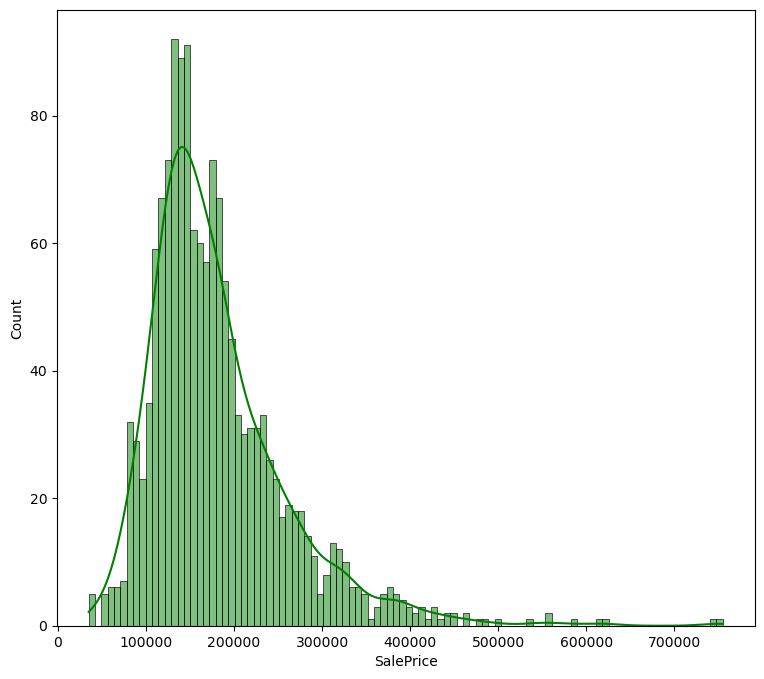

In [14]:
plt.figure(figsize=(9, 8))
sns.histplot(df['SalePrice'], color='g', bins=100, kde=True);

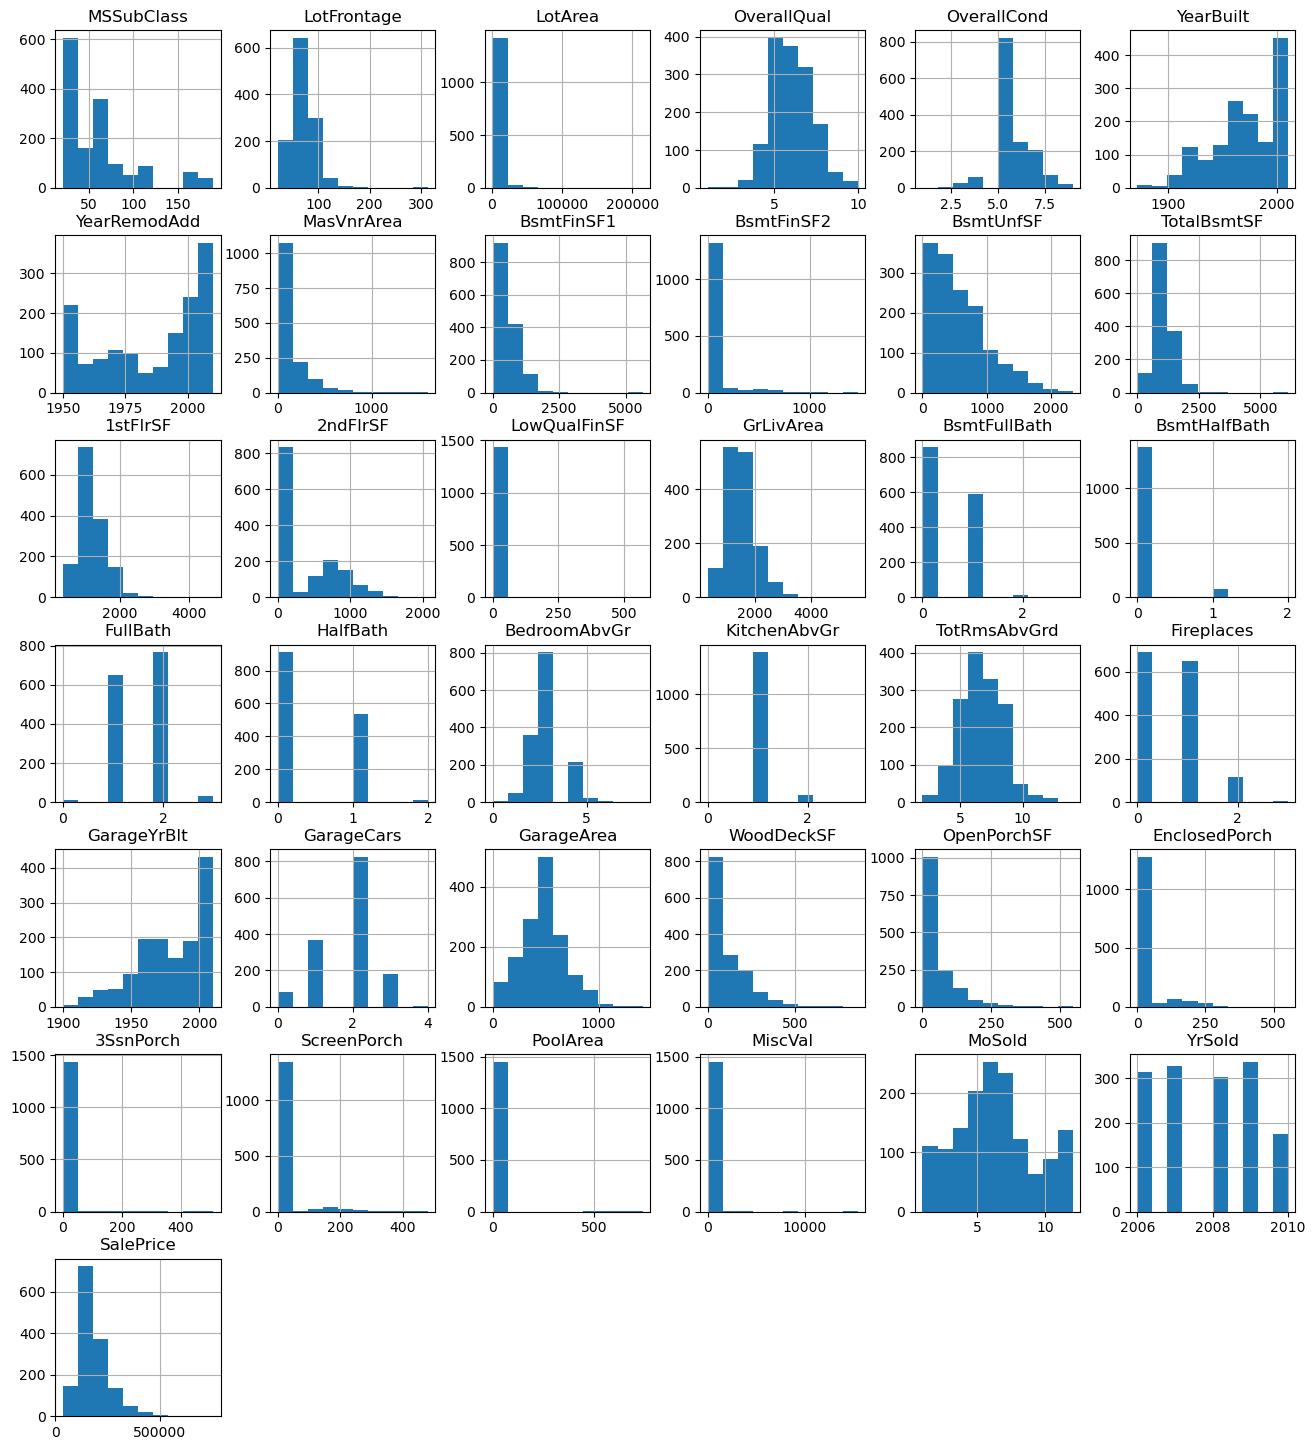

In [15]:
df.hist(figsize=(16,18));

# <u>Preprocessing:

In [16]:
# Define X and Y and complete the train test split
X = df.drop(columns = 'SalePrice')
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [17]:
# Categorical Pipeline
nom_cols = X_train.select_dtypes('object').columns
# Using value 'MISSING' for
impute_missing = SimpleImputer(strategy='constant',fill_value='MISSING')
nom_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
nom_pipe = make_pipeline(impute_missing, nom_encoder)
nom_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [18]:
# Numeric Pipeline
num_cols = X_train.select_dtypes('number').columns

mean_imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

num_pipe = make_pipeline(mean_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [19]:
num_tuple = ('numeric', num_pipe, num_cols)
nom_tuple = ('categorical', nom_pipe, nom_cols)

In [20]:
# Column transformer
preprocessor = ColumnTransformer([num_tuple, nom_tuple],
                                    verbose_feature_names_out=False)

In [21]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
X_train_proc.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1024,1.475911,-1.202174,-0.683950,0.637073,-0.515364,1.107889,1.020374,-0.521852,-0.944261,-0.284678,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
811,-0.871228,0.333763,-0.054883,-0.094926,0.390453,0.094543,0.682585,-0.025509,0.469362,2.166141,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1385,-0.167086,-0.456147,-0.152524,-0.094926,-0.515364,-1.049557,-1.681937,-0.603603,-0.533502,-0.284678,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
627,-0.871228,0.000000,0.144198,-0.826925,-0.515364,-0.363097,-0.330782,-0.603603,-0.979219,-0.284678,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
814,-0.871228,0.202111,-0.090142,-0.094926,0.390453,-0.428474,-1.295893,0.815355,0.349193,-0.284678,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# <u> Model 1

In [22]:
# Set Random Seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Instantiate your sequential model
model_1 = Sequential()
# Add first hidden layer with 3 neurons THIS IS NOT THE INPUT LAYER!
# Tell Keras how to construct the input layer shape using input_dim
model_1.add(Dense(10, activation='relu', input_dim=X_train_proc.shape[1]))
model_1.add(Dense(10, activation='relu'))

# Add output layer with 1 node
model_1.add(Dense(1, activation='linear'))

# Check summary of network
model_1.summary()
# Compile your model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                3010      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________


In [23]:
from tensorflow.keras.metrics import RootMeanSquaredError
tf.keras.optimizers.legacy.Adam()

In [24]:
rmse = RootMeanSquaredError()

model_1.compile(loss='mse', optimizer='adam', metrics=['mae', rmse])

In [25]:
# Fitting the data
history = model_1.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                         validation_split = .3, epochs = 100)

Epoch 1/100
35/35 [==============================] - 1s 10ms/step - loss: 39090270208.0000 - mae: 181710.7656 - root_mean_squared_error: 197712.5938 - val_loss: 38883414016.0000 - val_mae: 178544.3750 - val_root_mean_squared_error: 197188.7812
Epoch 2/100
35/35 [==============================] - 0s 4ms/step - loss: 39088386048.0000 - mae: 181705.8281 - root_mean_squared_error: 197707.8281 - val_loss: 38880743424.0000 - val_mae: 178537.3125 - val_root_mean_squared_error: 197182.0000
Epoch 3/100
35/35 [==============================] - 0s 3ms/step - loss: 39084695552.0000 - mae: 181696.1094 - root_mean_squared_error: 197698.5000 - val_loss: 38875885568.0000 - val_mae: 178524.5781 - val_root_mean_squared_error: 197169.6875
Epoch 4/100
35/35 [==============================] - 0s 3ms/step - loss: 39078305792.0000 - mae: 181679.3906 - root_mean_squared_error: 197682.3281 - val_loss: 38867832832.0000 - val_mae: 178503.5156 - val_root_mean_squared_error: 197149.2656
Epoch 5/100
35/35 [========

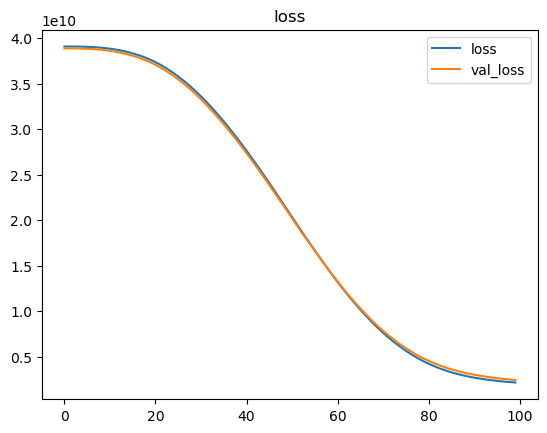

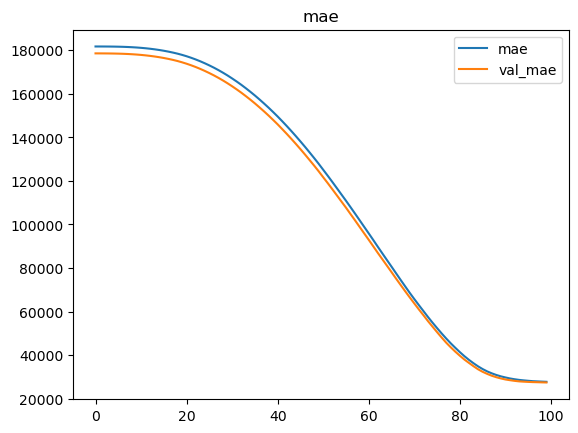

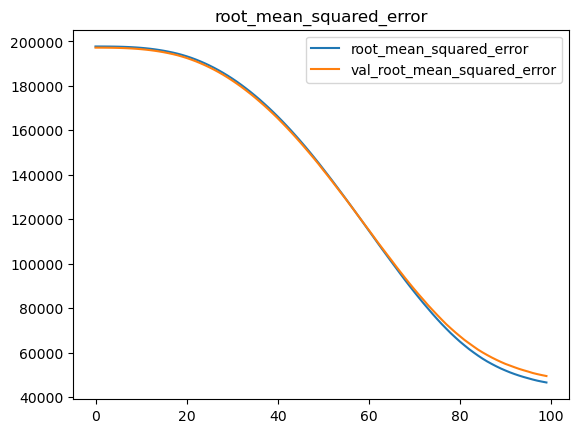

In [26]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history)

In [27]:
# Make predictions and evaluate your model
train_preds = model_1.predict(X_train_proc)
test_preds = model_1.predict(X_test_proc)

train_scores = eval_regression(y_train, train_preds, name='base_reg_train')
test_scores = eval_regression(y_test, test_preds, name='base_reg_test')

scores = pd.concat([train_scores, test_scores])
scores

12/12 [==============================] - 0s 1ms/step


,RMSE,MAE,R2
Model Name,,,
base_reg_train,46380.913248,27761.906186,0.645687
base_reg_test,49477.579243,27485.912265,0.650546


- #### This model has low variance so I will look at the bias.

# <u> Model 2
- Adding more hidden layers and more neurons in the 1st layer with a .35 dropout.

In [28]:
# Set Random Seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Instantiate your sequential model
model_2 = Sequential()
# Add first hidden layer with 3 neurons THIS IS NOT THE INPUT LAYER!
# Tell Keras how to construct the input layer shape using input_dim
model_2.add(Dense(15, activation='relu', input_dim=X_train_proc.shape[1]))
model_2.add(Dense(10, activation='relu'))
model_2.add(Dense(5, activation='relu'))
model_2.add(Dropout(.35))

# Add output layer with 1 node
model_2.add(Dense(1, activation='linear'))

# Check summary of network
model_2.summary()
# Compile your model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                4515      
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 4,736
Trainable params: 4,736
Non-trainable params: 0
_________________________________________________________________


In [29]:
rmse = RootMeanSquaredError()

model_2.compile(loss='mse', optimizer='adam', metrics=['mae', rmse])

In [30]:
history_2 = model_2.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        validation_split = .3, verbose = 0,
                        epochs = 100)

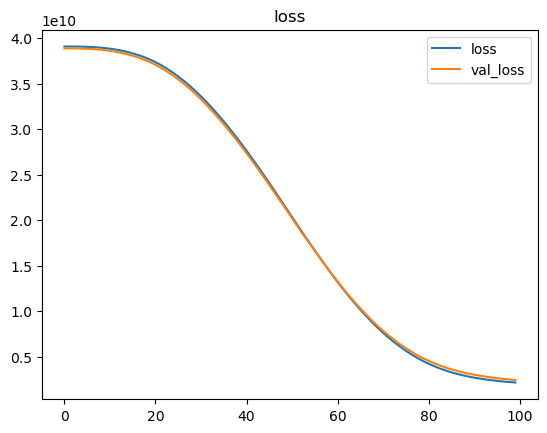

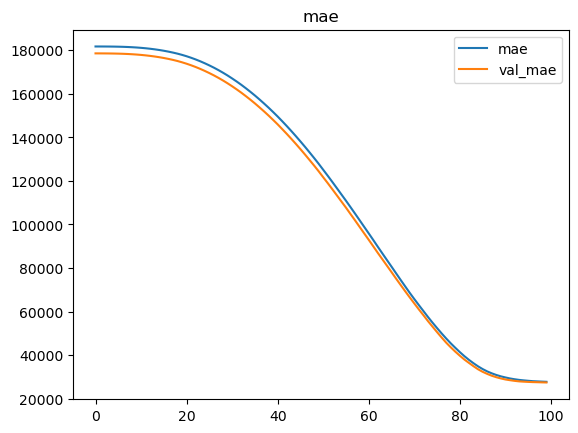

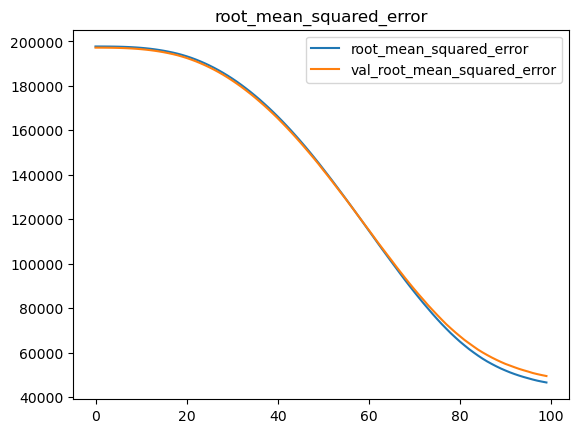

In [31]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history)

In [32]:
# Make predictions and evaluate your model
train_preds = model_2.predict(X_train_proc)
test_preds = model_2.predict(X_test_proc)

train_scores = eval_regression(y_train, train_preds, name='2nd_reg_train')
test_scores = eval_regression(y_test, test_preds, name='2nd_reg_test')


scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

12/12 [==============================] - 0s 2ms/step


,RMSE,MAE,R2
Model Name,,,
base_reg_train,46380.913248,27761.906186,0.645687
base_reg_test,49477.579243,27485.912265,0.650546
2nd_reg_train,54770.511267,39408.356171,0.505915
2nd_reg_test,57685.755851,40178.115090,0.524982


- #### Adding layers and changing the number of neurons improve the model.
- #### Will be trying a L1 regularization and increase the number of epochs to 300, looking to improve a less complex model.

# <u> Model 3

In [33]:
from keras.regularizers import l1

In [34]:
# Set Random Seeds
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Instantiate your sequential model
model_3 = Sequential()
# Add first hidden layer with 3 neurons THIS IS NOT THE INPUT LAYER!
# Tell Keras how to construct the input layer shape using input_dim
model_3.add(Dense(10, activation='relu', input_dim=X_train_proc.shape[1],
                  kernel_regularizer=l1(0.001)))
model_3.add(Dense(10, activation='relu',
                  kernel_regularizer=l1(0.001)))

# Add output layer with 1 node
model_3.add(Dense(1, activation='linear'))

# Check summary of network
model_3.summary()
# Compile your model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                3010      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,131
Trainable params: 3,131
Non-trainable params: 0
_________________________________________________________________


In [35]:
rmse = RootMeanSquaredError()

model_3.compile(loss='mse', optimizer='adam', metrics=['mae', rmse])

In [36]:
history = model_3.fit(X_train_proc, y_train,
                        validation_data = (X_test_proc, y_test),
                        validation_split = .3, epochs = 300,
                        verbose=0)

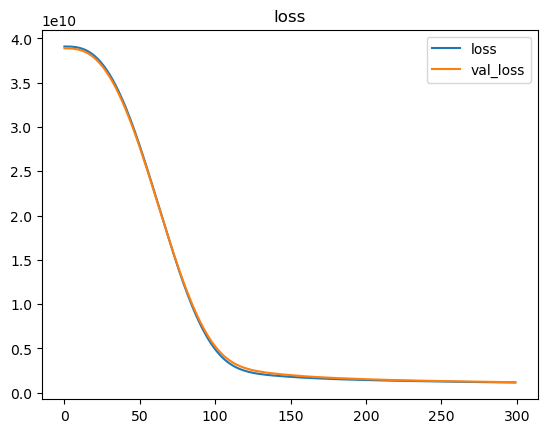

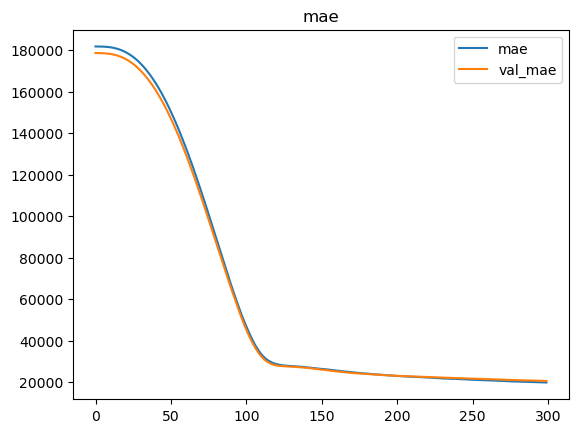

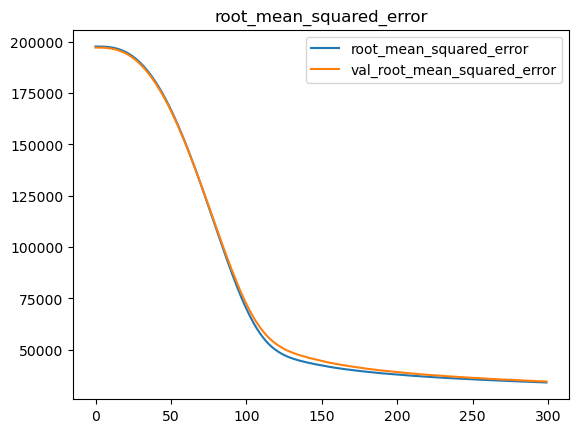

In [37]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history)

In [38]:
# Make predictions and evaluate your model
train_preds = model_3.predict(X_train_proc)
test_preds = model_3.predict(X_test_proc)

train_scores = eval_regression(y_train, train_preds, name='3rd_reg_train')
test_scores = eval_regression(y_test, test_preds, name='3rd_reg_test')

scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

12/12 [==============================] - 0s 2ms/step


,RMSE,MAE,R2
Model Name,,,
base_reg_train,46380.913248,27761.906186,0.645687
base_reg_test,49477.579243,27485.912265,0.650546
2nd_reg_train,54770.511267,39408.356171,0.505915
2nd_reg_test,57685.755851,40178.115090,0.524982
3rd_reg_train,34046.977920,19833.707748,0.809074
3rd_reg_test,34537.381518,20592.667134,0.829725


## <u>Best Model:

- #### The best model was the 3rd with R2 of .80 and the lowest MAE and RMSE

# <u>Optional (but fun!)
* Use your best model to make predictions using the features in test.csv.* 
Submit to the Kaggle competition to see how you did
* 
Include a screenshot of your results from the Kaggle competition inserted in a markdown cell at the bottom of your notebook.